In [52]:
%load_ext autoreload
%autoreload 2
from paths import *

from matplotlib import pyplot as plt
import torch
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.plotting.save_plot import save_plot
from src.plotting.AE_plotting import plot_loss
# import make_axes_locatable
import numpy as np
import dill
import io

# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_30416\2314663100.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [13]:
dill.Unpickler

dill._dill.Unpickler

In [100]:
# load model that has been trained on GPU on CPU. Source https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(dill.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_dill(file_name, experiment):
    file_name = os.path.join(results_dir, experiment, file_name)
    with open(file_name, 'rb') as f:
        contents = CPU_Unpickler(f).load()
    autoencoder = contents["model"]
    train_loss = contents["train_loss"]
    generator_num = contents["generator"]

    return autoencoder, train_loss, generator_num

In [102]:
generators_dict = {"generator1": 1, "generator2": 2, "generator3": 3}
labels_dict = {1: "alpha", 2: "c", 3: ["c", "alpha"]}

In [103]:
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.predefined_generator(generator_num)
dset_train = IterDataset(generator)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

Generator 1 , Loss:  0.25499506159262225
Generator 2 , Loss:  0.27013812552798877
Generator 3 , Loss:  0.33906932310624555


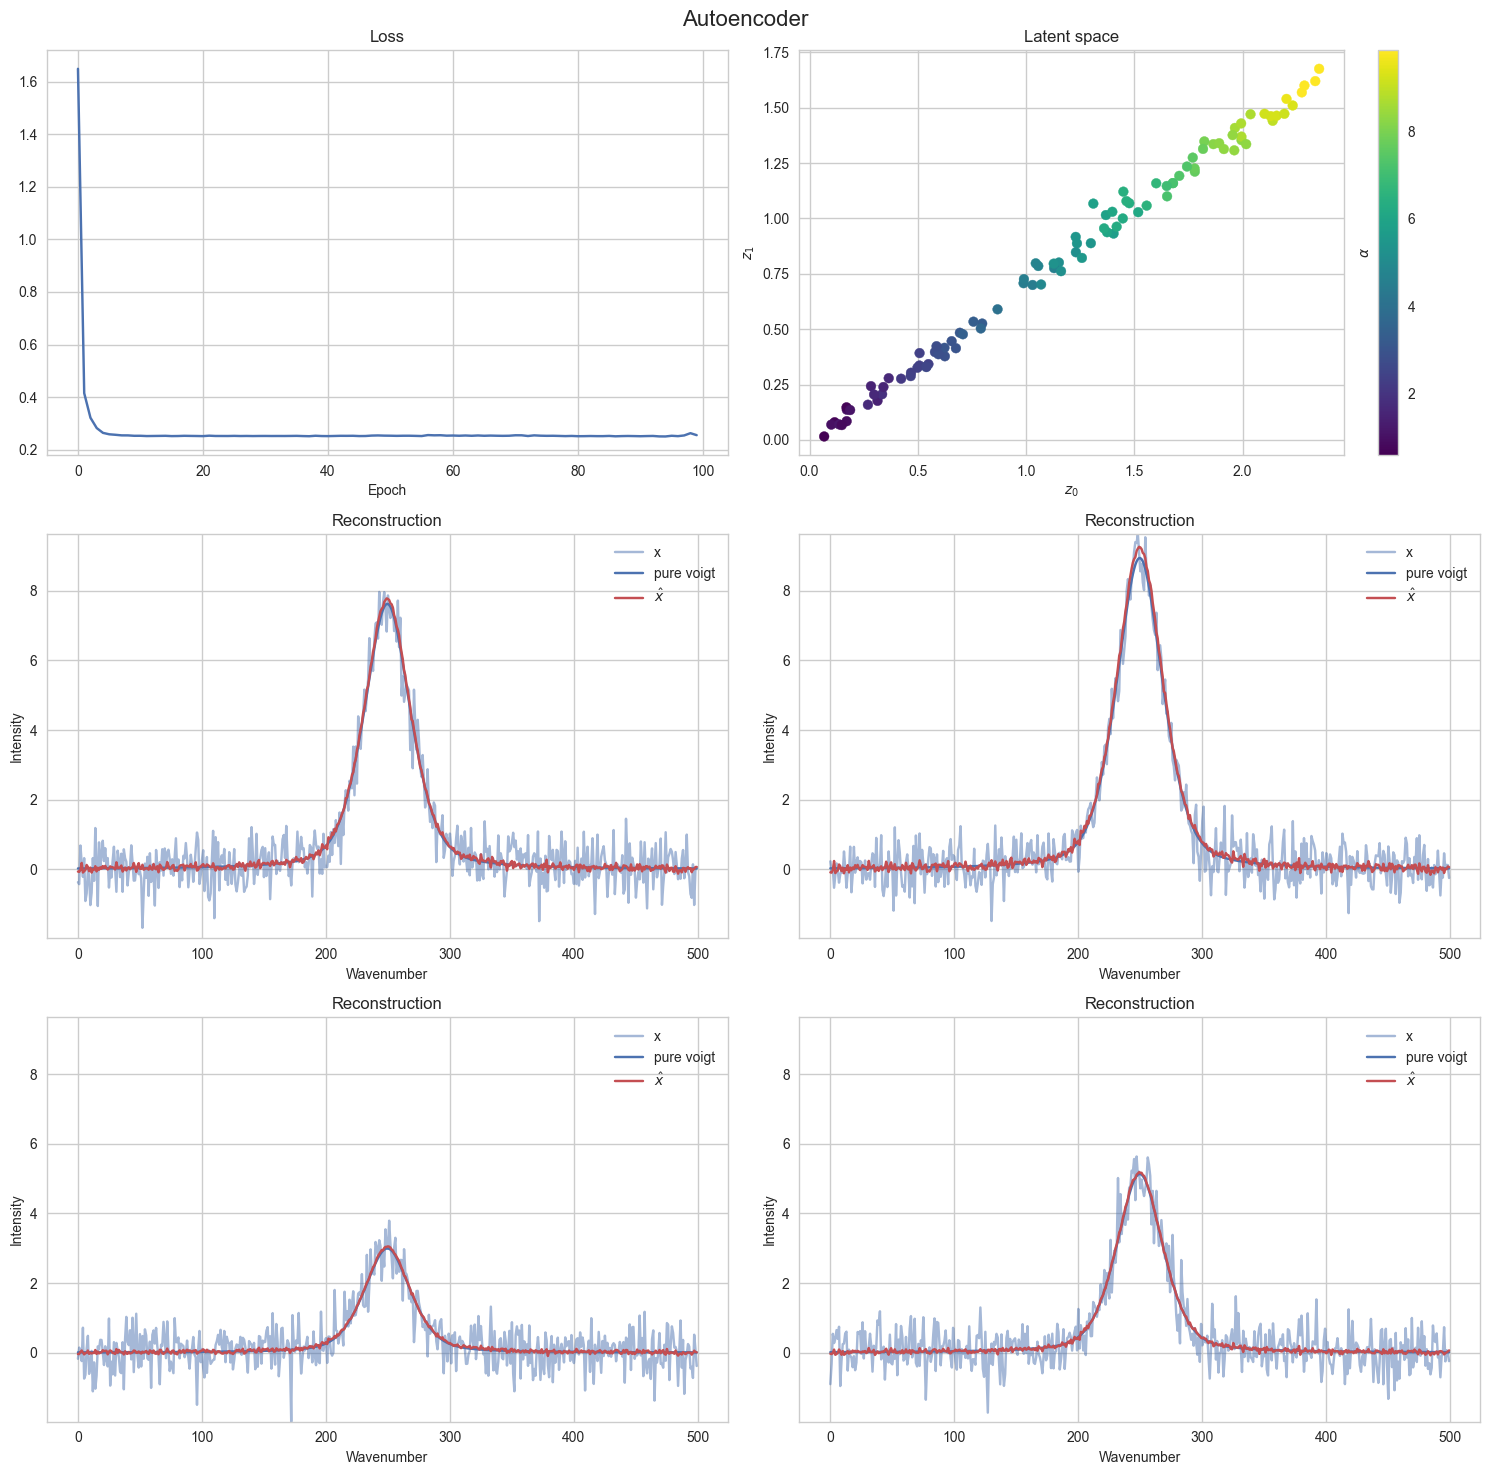

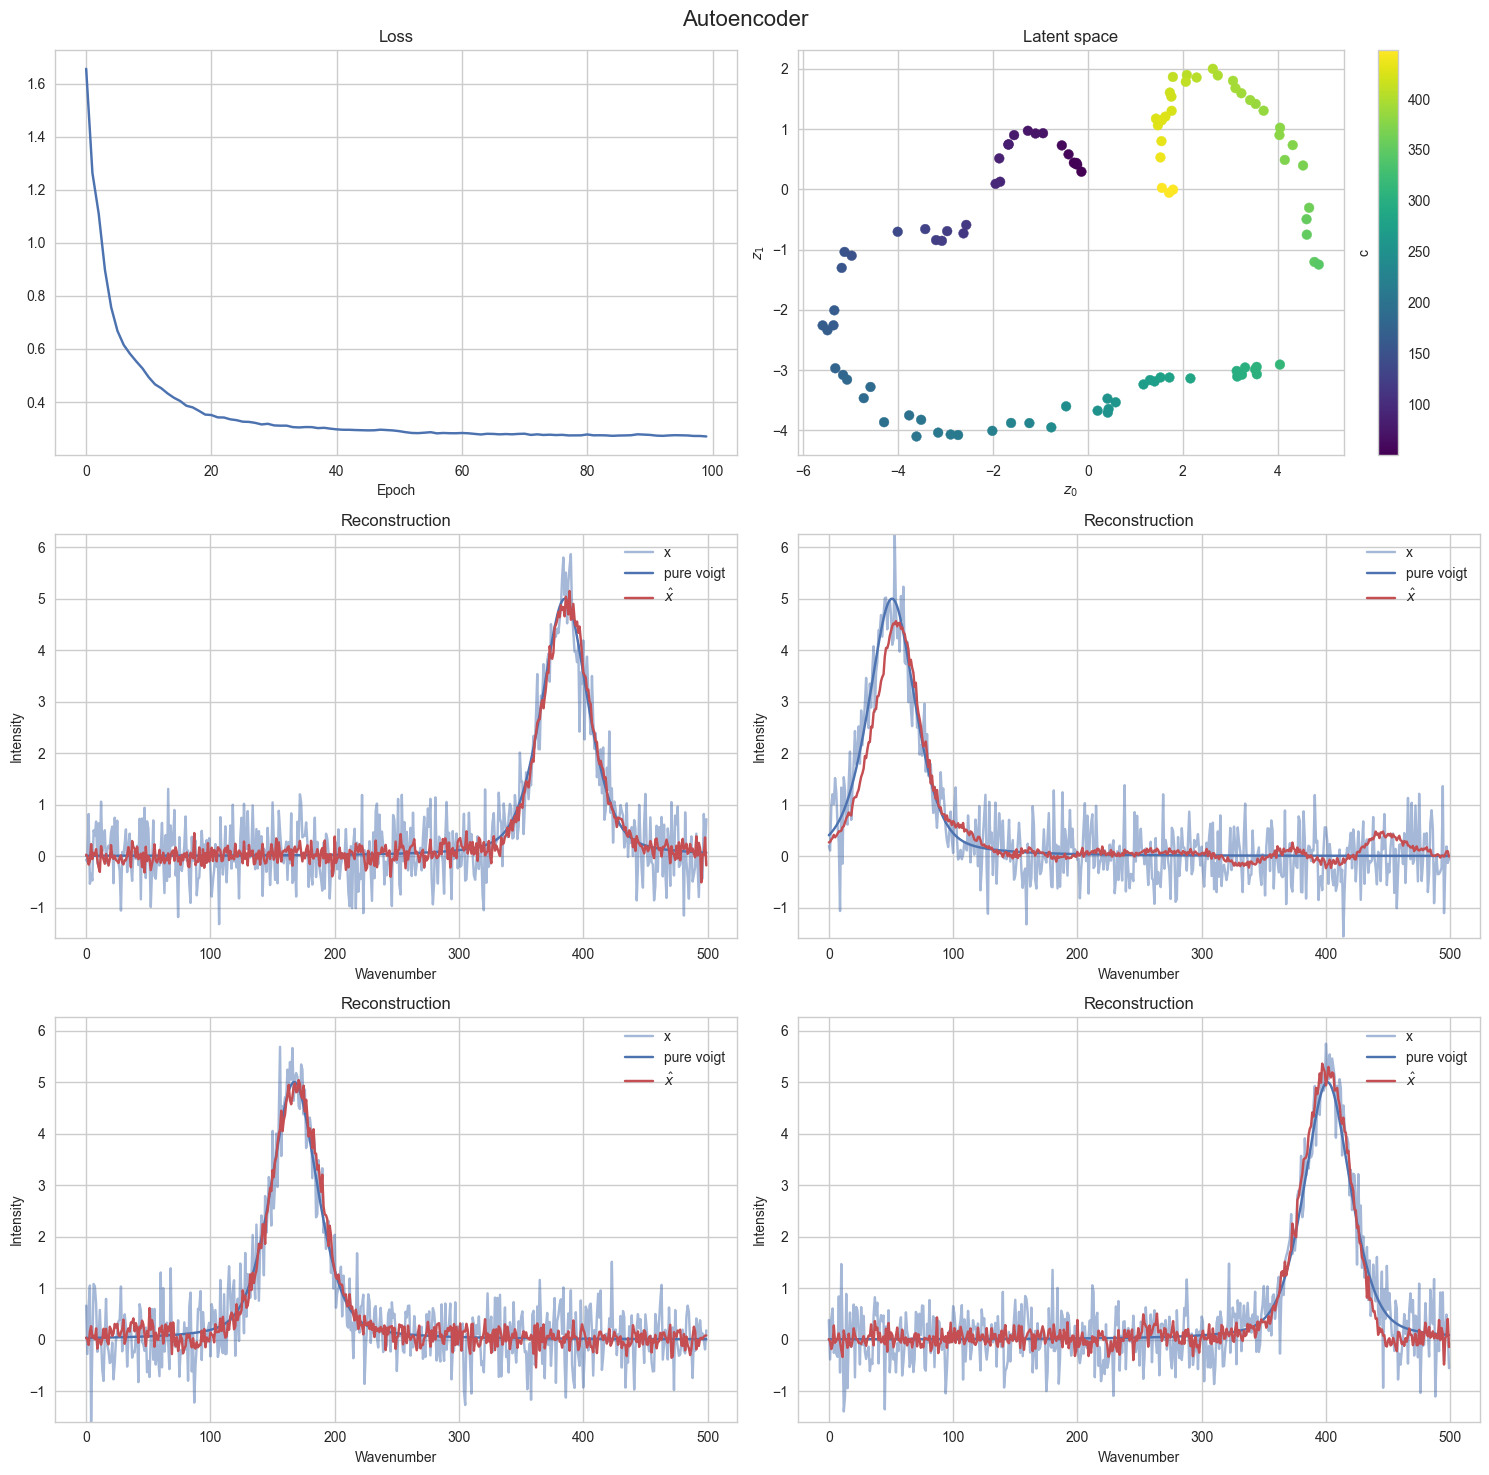

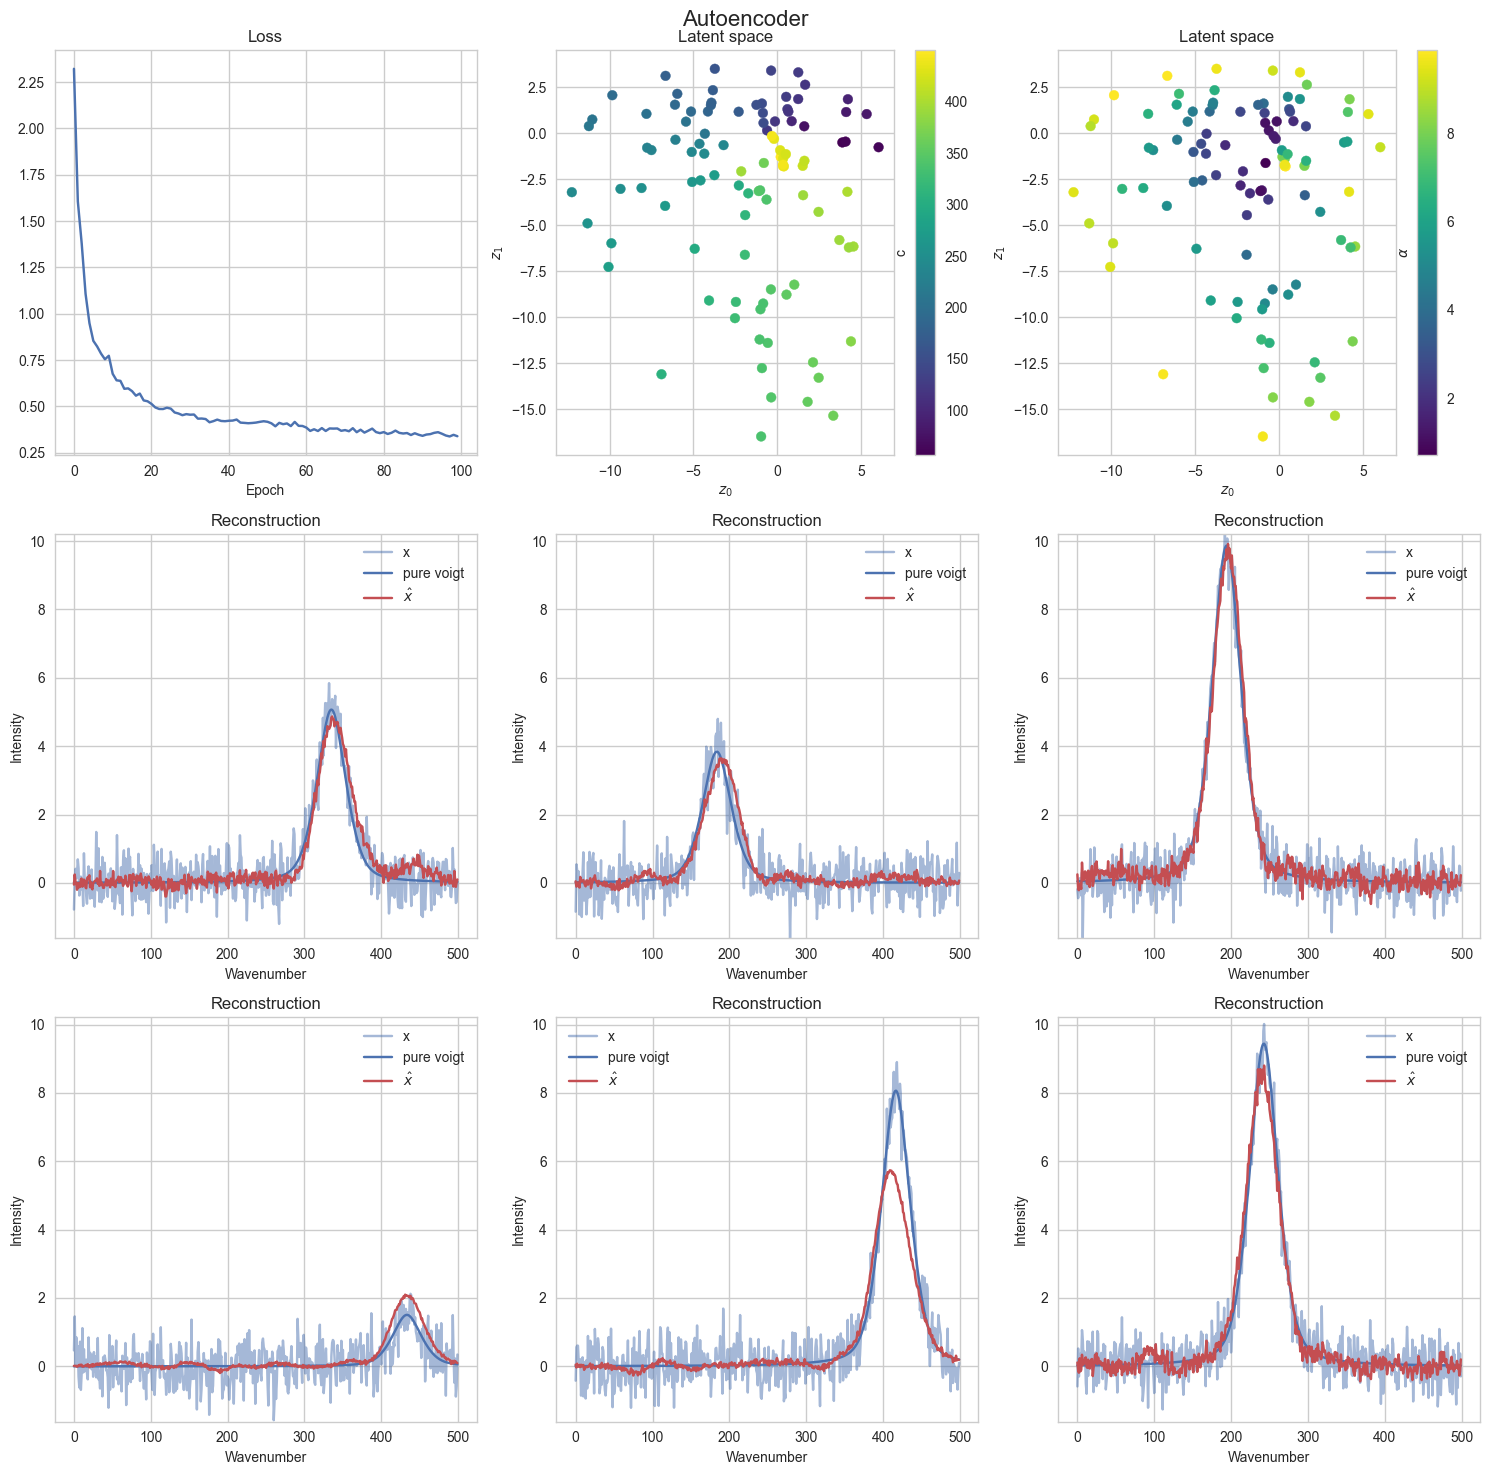

In [108]:
model_names = ['stellar-midichlorian-218', 'legendary-fighter-220', 'rebel-fighter-222']

for model_name in model_names:
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "1_AE")

    print("Generator", generator_num, ", Loss: ", train_loss[-1])

    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

    x, y = next(iter(train_loader))
    x = x.to(device)
    y = y.to(device)
    z = autoencoder.encoder(x)
    recons = autoencoder.decoder(z)
    label = labels_dict[generator_num]

    ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
    labels = []
    if isinstance(label, list):
        for l in label:
            labels.append(y[:,ll[l]])
    else:
        labels.append(y[:,ll[label]])
        label = [label]

    plot, fig, tmp_img =  plot_loss(train_loss, x, recons, z, labels, label, y, tmp_img="ae_tmp2.png")

    save_plot(plot, os.path.join(report_dir, "figures", "results", "1_AE", "autoencoder" + "_" + "_".join(label)), ["pdf", "png"])